# Band tailing from 3D Cu-Zn disorder in CZTS:

## 1. Introduction

### Analysis of distribution of Cu and Sn on-site electrostatic potentials

The distribution for Cu ions is used to infer band tailing of the VBM and the distribution for Sn ions is used to infer band tailing of the CBM due to the pDOS composition of the band extrema in CZTS, as shown below in the band structure.

Later in the notebook we also produce visuals of spatial variation in the electrostatic potentials for Cu or Sn in 2D slices.

![image](https://user-images.githubusercontent.com/8959058/42238164-df8cc45a-7ef7-11e8-9399-9ded2c339541.png)
(Fig. from doi: 10.1002/adma.201203146)

### A note on Cu and Sn potential distributions
Note that for the perfectly ordered lattice at T=0K there is only one crystallographically unique Sn, therefore there is only 1 value for the potential and hence the standard deviation of the electrostatic potential is zero. For Cu there are 2 distinct sites (one in the Cu-Zn plane and one in the Cu-Sn plane), therefore the standard deviation is non-zero even for the ordered lattice.

## 2a. Converting potentials from Eris internal units to V (!!need to review!!)
V = $\frac{Q}{4 \pi \epsilon_{0} \epsilon_{CZTS} r}$
- Q = bare formal charge of ion * e
- e = $1.6\times10^{-19} C$ 
- $\epsilon_{0} = 8.85 \times 10^{-12} C V^{-1} m^{-1}$ 
- $\epsilon_{CZTS}$ for perfect CZTS (most similar case to our lattice model) = 9.9 (doi: 10.1063/1.5028186)
- 1 Eris lattice unit = 2.72 Angstroms = 2.72 $\times10^{-10}$ m
- In Eris, only consider (bare formal charge)/ d, where d is ion separation in lattice units
- **To convert from Eris internal units to V, multiply result by conversion factor: $\frac{e}{4\pi \epsilon_{0} \epsilon_{CZTS} \times 2.72 \times10^{-10}}$ = 0.534**

## 2b. Notes for reviewing unit scaling
Exposed charge of a Cu-on-Zn and Zn-on-Cu antisite will first be screened by local electronic rearrangement, before being screened by (bulk dielectric constant)/ r, where only the latter is accounted for in our model.

### Next steps
1. Compare change in site potential before/ after generating a Cu/ Zn antisite pair in Eris and in Gulp
2. Look at effective charges on defect sites from year1 defect calcs with VASP

#### p.o.a. for 1
Run std Eris calc at T=0K and just 1 MC step for:
1. Make new function in eris-lattice.c to manually initialise 64 atom supercell (4x4x4 lattice) in Eris: output **ALL** potentials and gulp input file 
2. Modify above initial lattice function to have one n.n. Cu/ Zn antisite pair: output **ALL** potentials and gulp input file

Use gulp to compute on-site potentials for perfect 64 atom system and one with one Cu/ Zn antisite

#### Eris development
1. Make sure there is a function the uses potential_at_site_cube to output all potentials
2. Code up new manual lattice initialisation for perfect 64 atom supercell (4x4x4 lattice) and to introduce one n.n Cu/ Zn antisite pair

***Make sure to update unit_conversion variable in scripts below and/ or set up here instead***


## 3. Visualising the potential distributions (optional)
Choose a temperature and run the script below to produce a histogram and kernel density estimate for the potential distributions of Cu and Sn. This step is largely just to inspect that the data is approximately normally distributed. Feel free the vary the number of bins used to produce the histogram (i.e. the variable 'bin_num' below temp)

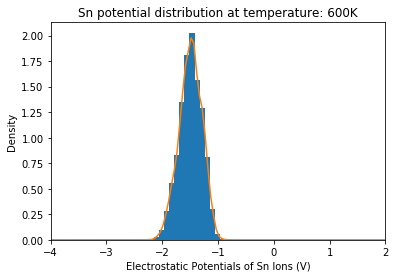

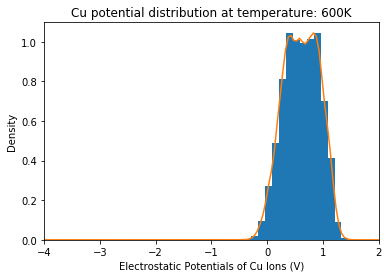

In [19]:
# Script to generate a histogram and kernal density estimate of Cu and Sn distributions
# Note: get an error if the distribution is a delta function/ singularity (i.e. no disorder yet!)
# It is useful to refer to the S vs T or PCF peak vs T plots when deciding which T to plot

%matplotlib inline
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy import stats

### Choose T to plot for
temp = 600 #in K
bin_num =15
unit_conversion = 0.534 # Defined in cell 2


T_formatted = str(temp).zfill(4)
Cu_file = "Cu_potentials_T_"+str(T_formatted)+"K.dat"
Sn_file = "Sn_potentials_T_"+str(T_formatted)+"K.dat"
Cu_potentials = np.genfromtxt(Cu_file)
Sn_potentials = np.genfromtxt(Sn_file)



# For Sn ---------------------------------------------------------------------------------------------

# Calculating kernal density estimate of Sn potential distribution of final lattice for specified simulation T
Sn_potentials_V = Sn_potentials*unit_conversion
Sn_kernel_density_est = stats.gaussian_kde(Sn_potentials_V)
Sn_pot_range_eval = np.linspace(-5, 5, num=200)

plt.xlabel('Electrostatic Potentials of Sn Ions (V)')
plt.ylabel('Density')
plt.title('Sn potential distribution at temperature: '+ str(temp) +'K')

plt.hist(Sn_potentials_V, normed=True, bins=bin_num)
plt.plot(Sn_pot_range_eval, Sn_kernel_density_est(Sn_pot_range_eval), label="Temperature: "+str(temp)+"K")

plt.xlim(-4,2)
#plt.ylim((0,6))
plt.show()

# For Cu ---------------------------------------------------------------------------------------------

# Calculating kernal density estimate of Cu potential distribution of final lattice for specified simulation T
Cu_potentials_V = Cu_potentials*unit_conversion
Cu_kernel_density_est = stats.gaussian_kde(Cu_potentials_V)
Cu_pot_range_eval = np.linspace(-5, 5, num=200)

plt.xlabel('Electrostatic Potentials of Cu Ions (V)')
plt.ylabel('Density')
plt.title('Cu potential distribution at temperature: '+ str(temp) +'K')
#plt.ylim((0,0.3))
plt.xlim(-4,2)

plt.hist(Cu_potentials_V, normed=True, bins=bin_num)
plt.plot(Cu_pot_range_eval, Cu_kernel_density_est(Cu_pot_range_eval), label="Temperature: "+str(temp)+"K")


plt.show()

## 4. Calculate mean and variance of distributions at each T
Run the script below to compute the mean and variance of Cu and Sn potential distributions at each T. These will be outputted to the file: 'Gaussian_params_Cu.dat' and 'Gaussian_params_Sn.dat'. Columns are: T, mean, variance, standard deviation

As the name implies, these parameters will be used to apply a Guassian broadening to the electron pDOS of Cu and Sn at the VBM and CBM of CZTS.

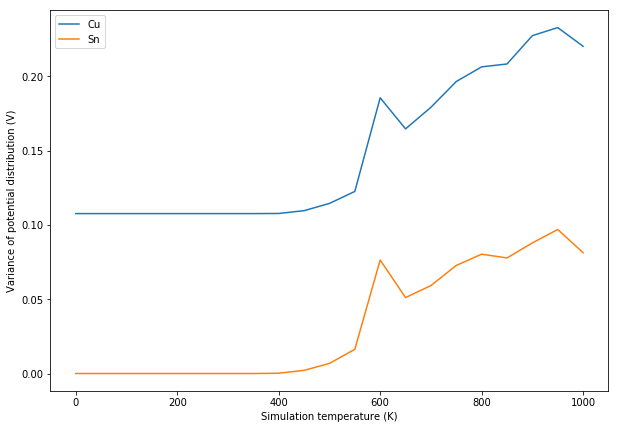

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### USER INPUTS ###
# Temperature range and step size from Eris simulation (as defined in cx1 submission script)
TMIN = 0
TMAX = 1000
TSTEP = 50
###################

### ADD IN CONVERSION FROM INTERNAL ERIS UNITS TO V HERE ###
unit_conversion = 0.534 #Convert from internal Eris units to V (see cell 2)

Cu_Gauss_params = open("Gaussian_params_Cu.dat", "w")
Cu_Gauss_params.write("# T, mean, var, s.d\n")
Cu_mean_list = []
Cu_var_list = []
Sn_Gauss_params = open("Gaussian_params_Sn.dat", "w")
Sn_Gauss_params.write("# T, mean, var, s.d\n")
Sn_mean_list = []
Sn_var_list = []
T_list = np.arange(TMIN, TMAX+TSTEP, TSTEP)

for T in range(TMIN, TMAX+TSTEP, TSTEP):
    T_formatted = str(T).zfill(4)
    # Write to file for Cu potentials: T, distribution mean, variance
    Cu_file = "Cu_potentials_T_"+str(T_formatted)+"K.dat"
    Cu_potentials = np.genfromtxt(Cu_file)
    Cu_mean = np.mean(Cu_potentials)
    Cu_mean_list.append(Cu_mean*unit_conversion)
    Cu_var = np.var(Cu_potentials)
    Cu_var_list.append(Cu_var*unit_conversion)
    Cu_Gauss_params.write(str(T)+" ")
    Cu_Gauss_params.write(str(Cu_mean*unit_conversion)+" ")
    Cu_Gauss_params.write(str(Cu_var*unit_conversion)+" ")
    Cu_Gauss_params.write(str(np.sqrt(Cu_var)*unit_conversion)+"\n")  
    # Write to file for Sn potentials: T, distribution mean, variance
    Sn_file = "Sn_potentials_T_"+str(T_formatted)+"K.dat"
    Sn_potentials = np.genfromtxt(Sn_file)
    Sn_mean = np.mean(Sn_potentials)
    Sn_mean_list.append(Sn_mean*unit_conversion)
    Sn_var = np.var(Sn_potentials)
    Sn_var_list.append(Sn_var*unit_conversion)
    Sn_Gauss_params.write(str(T)+" ")
    Sn_Gauss_params.write(str(Sn_mean*unit_conversion)+" ")
    Sn_Gauss_params.write(str(Sn_var*unit_conversion)+" ")
    Sn_Gauss_params.write(str(np.sqrt(Sn_var)*unit_conversion)+"\n") 

Cu_Gauss_params.close()
Sn_Gauss_params.close()

### Option to plot variance vs. T for Cu and Sn
fig = plt.figure(figsize = (10,7))
plt.plot(T_list, Cu_var_list, label="Cu")
plt.plot(T_list, Sn_var_list, label="Sn")
plt.xlabel("Simulation temperature (K)")
plt.ylabel("Variance of potential distribution (V)")
plt.legend()
plt.show()

## 5. Plot the Gaussians (optional)
(Make sure to run cell 4 first)

Run the script below to plot the Gaussian functions generated from the mean and variance of the Cu and Sn potential distributions. It may be useful to do this to compare to the plots from cell 3.

Lines in the plots are used to show the on-site potential for the perfectly ordered case at T=0K.

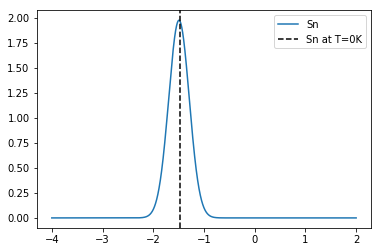

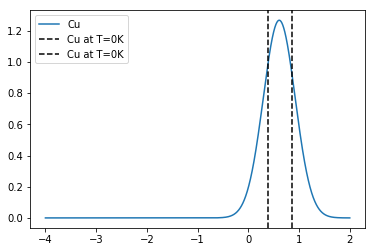

In [28]:
# Make sure to add line for perfectly ordered data! (can literally just do a line plot for T=0K raw data?)

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

### Choose T to plot for
temp = 600 #in K
unit_conversion = 0.534 # Defined in cell 2

# Reading in parameters for Gaussians to plot for T inputted by user
Cu_file = "Gaussian_params_Cu.dat"
Cu_params = np.genfromtxt(Cu_file)
i=0
for lines in Cu_params:
    if (Cu_params[i][0] == temp):
        #print(Cu_params[i][1])
        Cu_mean = Cu_params[i][1]
        Cu_var = Cu_params[i][2]
        Cu_sd = Cu_params[i][3]
    i += 1
Sn_file = "Gaussian_params_Sn.dat"
Sn_params = np.genfromtxt(Sn_file)
i=0
for lines in Sn_params:
    if (Sn_params[i][0] == temp):
        #print(Cu_params[i][1])
        Sn_mean = Sn_params[i][1]
        Sn_var = Sn_params[i][2]
        Sn_sd = Sn_params[i][3]
    i += 1
    
# Adding lines for ordered T=0K on-site potentials for Cu and Sn
Cu_ordered1 = 0.707362*unit_conversion # read in from 'Cu_potentials_T_0000K.dat'
Cu_ordered2 = 1.605296*unit_conversion
Sn_ordered = -2.761624*unit_conversion

# Set x_axis to be same for both plots as same as used in cell 3
x_axis = np.arange(-4, 2, 0.001)

# Plotting Gaussian and T=0K line for Sn
plt.plot(x_axis, norm.pdf(x_axis,Sn_mean,Sn_sd), label='Sn')
# Add 1 line for T=0K Sn
plt.axvline(x=Sn_ordered, color='black', linestyle='--', label='Sn at T=0K')
plt.legend()
plt.show()

# Plotting Gaussian and T=0K line for Cu
plt.plot(x_axis, norm.pdf(x_axis,Cu_mean,Cu_sd), label='Cu')
# Add 2 lines for T=0K Cu
plt.axvline(x=Cu_ordered1, color='black', linestyle='--', label='Cu at T=0K')
plt.axvline(x=Cu_ordered2, color='black', linestyle='--', label='Cu at T=0K')
plt.legend()
plt.show()


## 6a. 2D spatial variation in electrostatic potential
The script below can be used to generate plots showing the spatial variation of Cu or Sn in 2D slices of the lattice. In eris odd slice numbers correspond to Cu-Zn planes, even correspond to Cu-Sn planes.

In each plot, the mean of the potential distribution is subtracted from each on-site potential to show regions of higher or lower potential.

Please enter into the script below the simulation temperature and slice number you wish to plot (where the total number of slices is the Z dimension of your Eris lattice). If you enter an even number for the slice, plots will be generated for both Cu and Sn, if you enter an odd number only a plot for Cu will be generated.

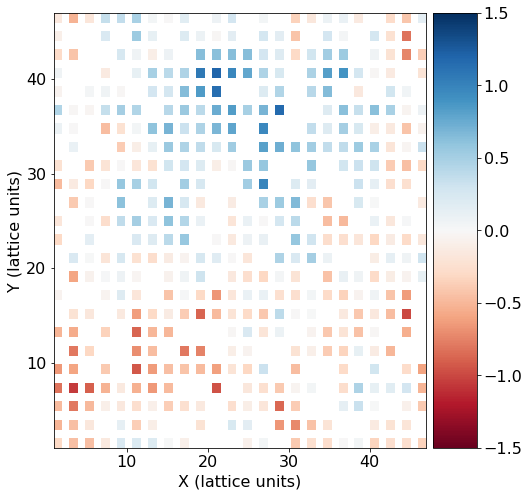

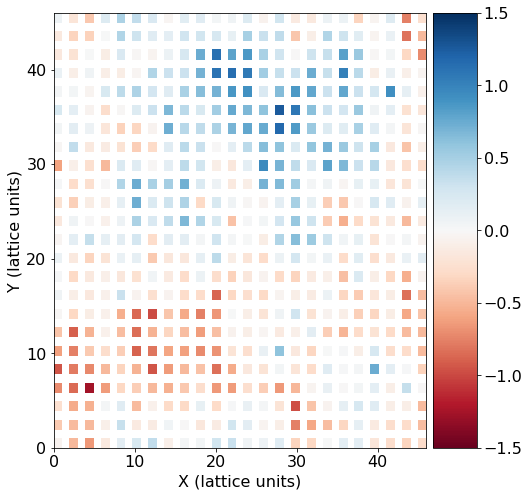

In [4]:
# NOTE: When using 'mean' method for histogram plot NaNs show up as white (i.e. sites not in data file in plots below)
# Also, Cu's move when plotting Cu-Zn plane slices but not when plotting Cu-Sn plane slices
# This is the only allowed disorder process in Eris currently (02.07.18) so is to be expected

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### USER INPUTS ###
T =950 # in K
slice_num = 12
X_dim = 48
Y_dim = 48
Z_dim = 24

# Set params for plots
cmap = 'RdBu' # Colormap (see matplotlib colormap docs for options)
pmin = -1.5 # Set limits for histogram plot of (onsite potential) - (mean potential)
pmax = 1.5
bins = X_dim-1 # Test bins in histogram plots
#bins = X_dim/2
# Bin choice a little arbitrary. 
# For on-lattice data may be better to read in X, Y coords to 2D array and use plt.imshow instead?
# e.g. plt.imshow(eris_pots_as_2d_array, cmap=plt.cm.cmap)  #cmap defined above


###################

unit_conversion = 0.534 #Convert from internal Eris units to V (see above for derivation)
T_formatted = str(T).zfill(4)
slice_formatted = str(slice_num).zfill(2)

# Generating plot for just Cu's in Cu-Zn slice
if (slice_num%2 == 1):
    data_file = "Cu_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    # Reading in data from eris output file
    CuZnSlice = np.genfromtxt(data_file, delimiter = ' ')
    x_vals = CuZnSlice[:,0]
    y_vals = CuZnSlice[:,1]
    pots = CuZnSlice[:,2]
    pot_mean = np.mean(pots)
    pot_fluc = CuZnSlice[:,2] - pot_mean
    pot_fluc_in_V = pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Cu in Cu-Zn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(x_vals, y_vals, values = pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig = plt.figure(figsize = (8,8))
    plt.rcParams.update({'font.size': 16})
    ax1=plt.subplot(111)
    #plt.title("T = "+str(T)+"K, Cu in Cu-Zn plane, slice = "+ str(slice_num))
    plot1 = ax1.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot1,ax=ax1, pad = .015, aspect=10)


    
# Generating separate plots for Cu's and Sn's in Cu-Sn slice   
if (slice_num%2 == 0):
    # Set up subplots
    Cu_data_file = "Cu_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    Sn_data_file = "Sn_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    # Reading in data from eris output file for Cu
    Cu_CuSnSlice = np.genfromtxt(Cu_data_file, delimiter = ' ')
    Cu_x_vals = Cu_CuSnSlice[:,0]
    Cu_y_vals = Cu_CuSnSlice[:,1]
    Cu_pots = Cu_CuSnSlice[:,2]
    Cu_pot_mean = np.mean(Cu_pots)
    Cu_pot_fluc = Cu_CuSnSlice[:,2] - Cu_pot_mean
    Cu_pot_fluc_in_V = Cu_pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Cu in Cu-Sn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(Cu_x_vals, Cu_y_vals, values = Cu_pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig = plt.figure(figsize = (8,8))
    plt.rcParams.update({'font.size': 16})
    ax1=plt.subplot(111)
    #plt.title("T = "+str(T)+"K, Cu in Cu-Sn plane, slice = "+ str(slice_num))
    plot1 = ax1.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot1,ax=ax1, pad = .015, aspect=10)
    plt.xlabel('X (lattice units)')
    plt.ylabel('Y (lattice units)')
    plt.savefig("spatial_pot_fluc_2D_Cu.png")
    # Reading in data from eris output file for Sn
    Sn_CuSnSlice = np.genfromtxt(Sn_data_file, delimiter = ' ')
    Sn_x_vals = Sn_CuSnSlice[:,0]
    Sn_y_vals = Sn_CuSnSlice[:,1]
    Sn_pots = Sn_CuSnSlice[:,2]
    Sn_pot_mean = np.mean(Sn_pots)
    Sn_pot_fluc = Sn_CuSnSlice[:,2] - Sn_pot_mean
    Sn_pot_fluc_in_V = Sn_pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Sn in Cu-Sn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(Sn_x_vals, Sn_y_vals, values = Sn_pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig2 = plt.figure(figsize = (8,8))
    plt.rcParams.update({'font.size': 16})
    ax2=plt.subplot(111)
    #plt.title("T = "+str(T)+"K, Sn in Cu-Sn plane, slice = "+ str(slice_num))
    plot2 = ax2.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot2,ax=ax2, pad = .015, aspect=10)
    plt.savefig("spatial_pot_fluc_2D_Sn.png")
    

plt.xlabel('X (lattice units)')
plt.ylabel('Y (lattice units)')

plt.show()


## 6b. 1D plot of (on-site potential) - (mean potential) for Cu's and Sn's across y=x
Make sure to run above cell first.

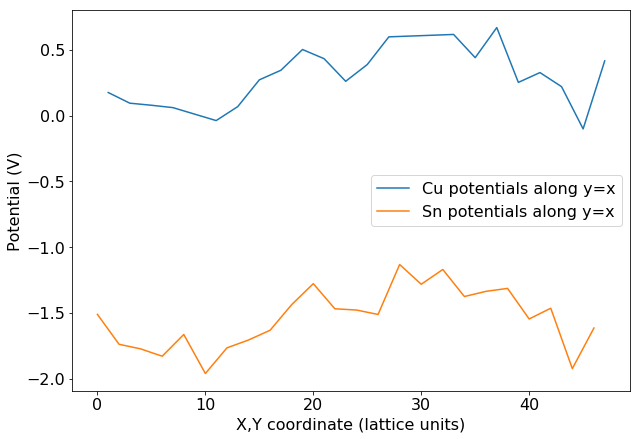

In [5]:
Cu_1D_pot = []
Cu_1D_coord = []
Sn_1D_pot = []
Sn_1D_coord = []
# Write y=x potentials for Cu    
for x,y,pot in zip(Cu_CuSnSlice[:,0], Cu_CuSnSlice[:,1], Cu_CuSnSlice[:,2]):
    if (int(x) == int(y)):
        Cu_1D_pot.append(pot*unit_conversion)
        Cu_1D_coord.append(x)
# Write y=x potentials for Sn    
for x,y,pot in zip(Sn_CuSnSlice[:,0], Sn_CuSnSlice[:,1], Sn_CuSnSlice[:,2]):
    if (int(x) == int(y)):
        Sn_1D_pot.append(pot*unit_conversion)
        Sn_1D_coord.append(x)
               
fig = plt.figure(figsize = (10,7))
plt.plot(Cu_1D_coord, Cu_1D_pot, label='Cu potentials along y=x')
plt.plot(Sn_1D_coord, Sn_1D_pot, label='Sn potentials along y=x')
plt.xlabel("X,Y coordinate (lattice units)")
plt.ylabel("Potential (V)")
plt.legend()
plt.show()